In [22]:
import pandas as pd
import gdown
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [23]:
# Paso 1: Descargar y cargar el dataset
url = 'https://drive.google.com/uc?id=1Eyei6msNpKNUA-pTcTIw_prHp-HAuESG'
output = 'TSLA.csv'
gdown.download(url, output, quiet=False)

tesla_data_df = pd.read_csv('TSLA.csv')

Downloading...
From: https://drive.google.com/uc?id=1Eyei6msNpKNUA-pTcTIw_prHp-HAuESG
To: /content/TSLA.csv
100%|██████████| 185k/185k [00:00<00:00, 57.8MB/s]


In [24]:
# Eliminar filas con valores nulos
tesla_data_df.dropna(inplace=True)


In [25]:
tesla_data_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,29-Jun-10,1.27,1.67,1.17,1.59,1.59,281494500.0
1,30-Jun-10,1.72,2.03,1.55,1.59,1.59,257806500.0
2,1-Jul-10,1.67,1.73,1.35,1.46,1.46,123282000.0
3,2-Jul-10,1.53,1.54,1.25,1.28,1.28,77097000.0
4,6-Jul-10,1.33,1.33,1.06,1.07,1.07,103003500.0
...,...,...,...,...,...,...,...
3729,23-Apr-25,254.86,259.45,244.43,250.74,250.74,150381900.0
3730,24-Apr-25,250.5,259.54,249.20,259.51,259.51,94464200.0
3731,25-Apr-25,261.69,286.85,259.63,284.95,284.95,167560700.0
3732,28-Apr-25,288.98,294.86,272.42,285.88,285.88,151731800.0


In [26]:
# Paso 2: Convertir 'Date' a datetime y establecer como índice
tesla_data_df['Date'] = pd.to_datetime(tesla_data_df['Date'], format='%d-%b-%y')
tesla_data_df.set_index('Date', inplace=True)

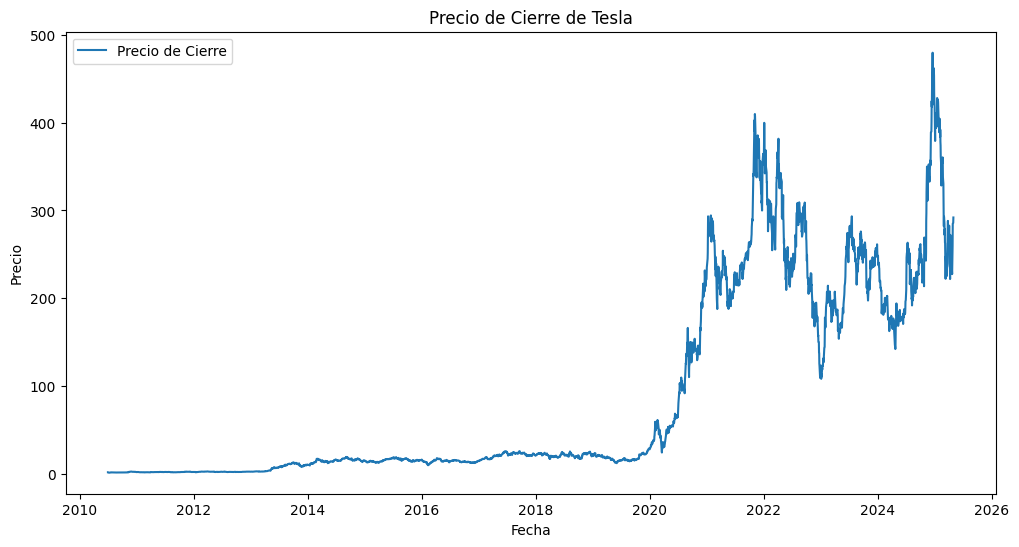

In [27]:
# Paso 3: Visualizar la serie de tiempo
plt.figure(figsize=(12, 6))
plt.plot(tesla_data_df['Close'], label='Precio de Cierre')
plt.title('Precio de Cierre de Tesla')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.savefig('tesla_close_price.png')
plt.show()


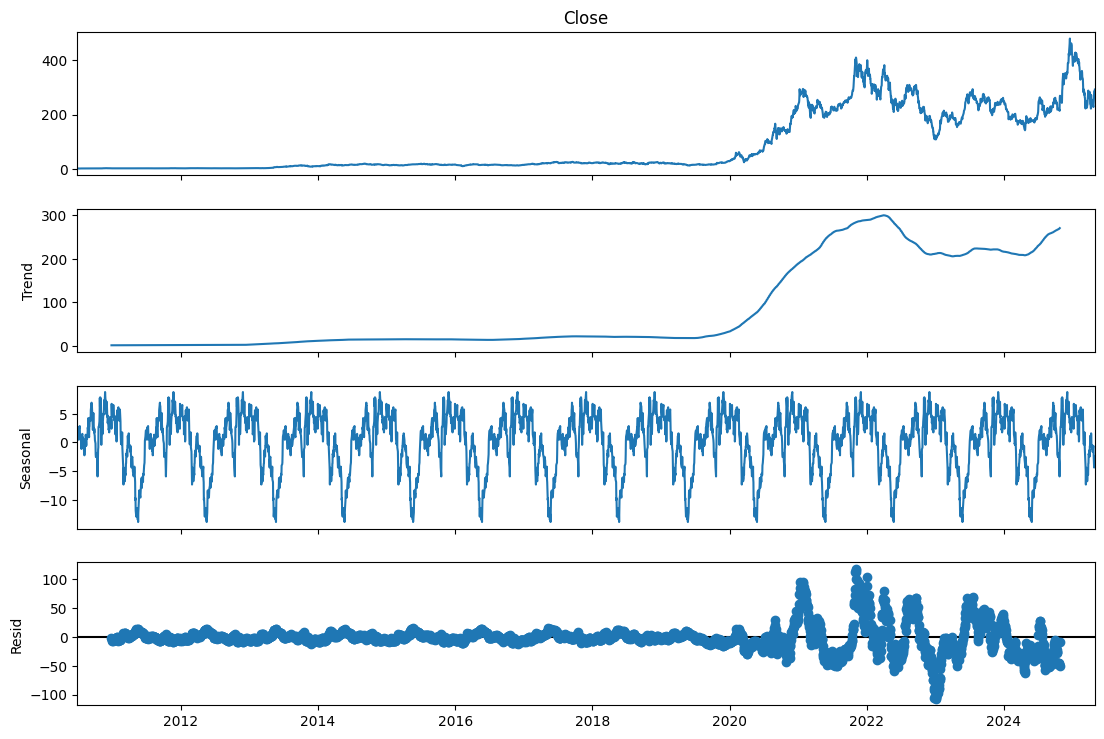

In [28]:
# Paso 4: Descomponer la serie para detectar estacionalidad
decomposition = seasonal_decompose(tesla_data_df['Close'], model='additive', period=252)  # 252 días hábiles por año
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.savefig('tesla_decomposition.png')
plt.show()

In [29]:
# Paso 5: Verificar estacionariedad con la prueba ADF
result = adfuller(tesla_data_df['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] > 0.05:
    print("La serie no es estacionaria. Aplicando diferenciación...")
    tesla_data_df['Close_diff'] = tesla_data_df['Close'].diff().dropna()
    result_diff = adfuller(tesla_data_df['Close_diff'].dropna())
    print('ADF Statistic (diff):', result_diff[0])
    print('p-value (diff):', result_diff[1])
else:
    print("La serie es estacionaria.")

ADF Statistic: -1.2983176938057928
p-value: 0.629941618917165
La serie no es estacionaria. Aplicando diferenciación...
ADF Statistic (diff): -11.017047427281256
p-value (diff): 6.119410344877847e-20


In [30]:
# Paso 6: Ajustar modelo según análisis
# Si hay estacionalidad (observada en la descomposición), usamos SARIMA
# model = SARIMAX(tesla_data_df['Close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 252))
# model_fit = model.fit(disp=False)
# print(model_fit.summary())

# Si no hay estacionalidad usamos ARIMA para ello se requiere una derivación
# Diferenciar la serie una vez para hacerla estacionaria
tesla_data_df['Close_diff'] = tesla_data_df['Close'].diff().dropna()

# Ajustar el modelo ARIMA (p, d, q) a la serie original
# Usamos d=1 porque diferenciamos una vez; p=1 y q=1 como ejemplo inicial
model = ARIMA(tesla_data_df['Close'], order=(1, 1, 1))
model_fit = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [31]:
# Mostrar el resumen del modelo
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3732
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11711.071
Date:                Thu, 08 May 2025   AIC                          23428.143
Time:                        00:46:29   BIC                          23446.816
Sample:                             0   HQIC                         23434.786
                               - 3732                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9819      0.014    -68.303      0.000      -1.010      -0.954
ma.L1          0.9863      0.012     79.829      0.000       0.962       1.010
sigma2        31.1816      0.246    126.685      0.0

ARIMA(1,1,1) predice el precio de cierre usando 3732 observaciones, con coeficientes significativos (ar.L1: -0.9819, ma.L1: 0.9863) y una varianza de error de 31.18. Aunque los errores son aleatorios (Ljung-Box: 0.20), no son normales (Jarque-Bera: 0.00), presentan alta kurtosis (18.73) y varianza no constante (Heteroskedasticity: 0.00), lo que indica que el modelo captura parte de la dinámica pero podría no ser ideal para datos volátiles como precios financieros debido a la presencia de valores extremos y cambios en la varianza.



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


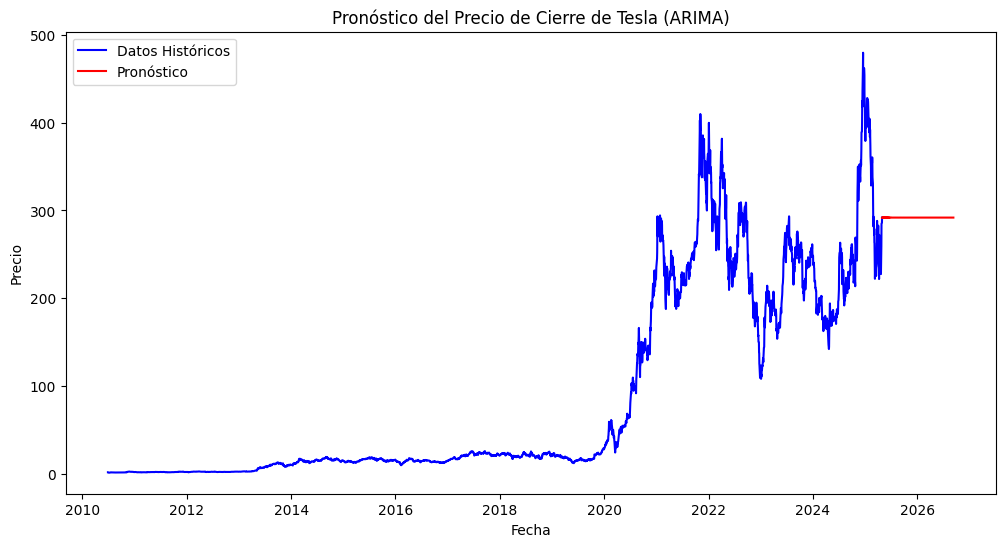

Pronóstico generado y guardado en 'tesla_forecast_arima.png'.


In [32]:
# Realizar pronóstico para los próximos 30 días
forecast = model_fit.forecast(steps=500)
forecast_dates = pd.date_range(start=tesla_data_df.index[-1], periods=500, freq='D')

# Visualizar los datos históricos y el pronóstico
plt.figure(figsize=(12, 6))
plt.plot(tesla_data_df['Close'], label='Datos Históricos', color='blue')
plt.plot(forecast_dates, forecast, label='Pronóstico', color='red')
plt.title('Pronóstico del Precio de Cierre de Tesla (ARIMA)')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.savefig('tesla_forecast_arima.png')
plt.show()

print("Pronóstico generado y guardado en 'tesla_forecast_arima.png'.")